# Cluster detection in Planck Maps with SZ effect

Work from Marilou Medawar (ObsPM, Paris) and Marine Prunier (ObsPM, Paris).

Under the supervision of Dr. Marian Douspis (IAS, Orsay)

### Abstract 

*Context*: 
    The European Space Agency PLANCK Satellite observed the Cosmic Microwave Background (CMB) at a high angular resolution and sensitivity measuring the temperature variations across this microwave background and providing a strong database for a better understanding of the anisotropies. In addition, PLANCK has also been designed to detect the signature of the Sunyaev-Zeldovich (SZ) effect corresponding to the spectral distortion of the CMB through inverse Compton scattering of the CMB photons by high-energy electrons present in distant galaxy clusters. 

*Goal*:
    Our aim in this work is to detect candidate galaxy clusters with the Sunyaev-Zeldovich effect component and compare them to the Planck 2nd Sunyaev-Zeldovich Source Catalog. 

*Method*:
    We extract the emission of thermal SZ from the Planck maps using a component separation method so-called Internal Linear Combination (ILC) Constrained to build clean All Sky SZ maps. Then, we develop a routine to detect the candidate galaxy clusters on a portion of the map.

*Results*: 
        We detect 8 candidate cluster on a 10° by 10° portion of our SZ map. We match most of the detected candidates with clusters cataloged in the Planck 2nd Sunyaev-Zeldovich Source Catalog with small relative errors. 


This repository contains:

    -Implementation of simple ILC Constrained (Internal Linear Combination) method (see (1), (2), (3)).
    
    -Visualization using HEALPix (Hierarchical Equal Area isoLatitude Pixelation of a sphere) python package (see (6))
    
    -Galaxy cluster detection on an image routine. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
 
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import sys

from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

plt.rcParams['font.size'] = 18


import healpy as hp

ModuleNotFoundError: No module named 'healpy'

# CMB and Planck Map

# Planck Map smoothing and pre-processing

The European Space Agency PLANCK Satellite observed the sky in 9 frequency channels. The data consists of several maps in HEALPix format. For this work, we used the high-frequency Planck Maps (HFI): 100 GHz, 143 GHz, 217 GHz, 353 GHz, 545 GHz, and 867 GHz. 
There are separate files for different frequencies. Each file contains pixels with temperatures.

In [ ]:

def clean_maps(map_frequency_list, nside, downgrade = True, print_map = True):
    """
    Function to put all the maps at the same resolution, 
    with option to downgrade the number of maps' pixel to avoid heavy maps.  
    Args:
    
    Return:
        List of maps (.fits) of same resolution.
    """
    path = "../../../../home/abeelen/Planck/maps"
    conversion_dict = {545: 58.04, 857: 2.27} # dictionnary to convert MJysr-1 in Kcmb 
    fwhm_target = 10 # targeted FWHM of 10 armin for all the maps
    infos = fits.getdata(path + "/HFI_RIMO_R2.00.fits", 2)
    counter = 0
    
    for map_frequency in map_frequency_list:

        map_cmb = hp.read_map(path + "/HFI_SkyMap_%i_2048_R2.00_full.fits" %map_frequency)
        print("Map HFI_SkyMap_%i_2048_R2.00_full.fits" %map_frequency, "is being processed.") 

        #conv product 2 gaussian fct = one gaussian fct of FWHM
        fwhm_final = np.sqrt(fwhm_target**2-infos[counter]["FWHM"]**2)

        fwhm_final_rad = fwhm_final*np.pi/(60 * 180)
        print("   Smoothing ...")
        map_cmb = hp.sphtfunc.smoothing(map_cmb, fwhm = fwhm_final_rad)

        if downgrade == True : 
            print("   Maps reduction to", nside, "pixels...")
            map_cmb = hp.pixelfunc.ud_grade(map_cmb, nside)

        if map_frequency > 544: 
            print("   Unit conversion to KCMB")
            map_cmb = map_cmb/conversion_dict.get(map_frequency)

        hp.write_map("Maps/Maps_Resolution_2048/HFI_SkyMap_%i_%i_R2.00_full_ready.fits"%(map_frequency,nside), map_cmb, overwrite=True)
        counter += 1
        
        if print_map == True: 
            mp= hp.read_map("Maps/Maps_Resolution_2048/HFI_SkyMap_%i_%i_R2.00_full_ready.fits"%(map_frequency,nside))
            hp.mollview(mp,norm="hist")
            hp.graticule()
            
            
map_frequency_list=[100, 143, 217, 353, 545, 857]
clean_maps(map_frequency_list, 2048)# sys.argv[1])

# Galaxy Mask

In order to obtain a clean SZ signal, we need to mask the emission of our own galaxy, which is mostly located on the galactic plane. For this purpose, we create a mask to remove most of the equatorial galaxy emissions.

In [2]:
def mask_create(thresh = 25, NSIDE = 2048):
    
    """
    Function to create a mask on the galaxy. 
    Args: threshold, percentage of the sky we want to mask.
    
    Return:
        The mask as an array of pixels to mask from the CMB maps.
    """
    
    # Map on which the mask is computed, we want to remove most
    # the galaxy without substracting the CMB. Therefore we compute the mask 
    # on the highest fq map where the grey-body emission from galaxy dust is the strongest.
    
    map_guide = hp.read_map("Maps/Maps_Resolution_2048/HFI_SkyMap_857_2048_R2.00_full_ready.fits")

    mask = np.ones(hp.nside2npix(NSIDE), dtype=np.double)
    
    map_arranged = np.sort(map_guide)
    
    thresh_ = (1-thresh/100) * len(map_arranged)
    
    map_to_cut = map_arranged[int(thresh_):]   
    
    mask[(map_guide > map_to_cut.min())] = 0
        
    return mask

mask = mask_create()

# Filtering Planck Maps with Angular scales

## Spherical Harmonical Filter

The astrophysical sources of the maps vary both spatially (pixel domain) and in frequency (spherical harmonic domain). For example, CMB is homogeneous and isotropic above the sky and dominates at a typical angular scale of about one degree. The signature of the SZ effect is dominant on a typical angular scale between 1 and 0.1 degrees. By decomposing the maps with respect to different angular scales, we are grouping each astrophysical source by looking at the sources having similar scales.

We create 3 filters to obtain three sets of CMB maps with 3 ranges of angular scales. One can plot here on the CMB Power Spectrum with the corresponding regions we are going to filter on the maps in spherical harmonics space.

Text(0, 0.5, 'Temperature fluctuation [$\\mu K^2$]')

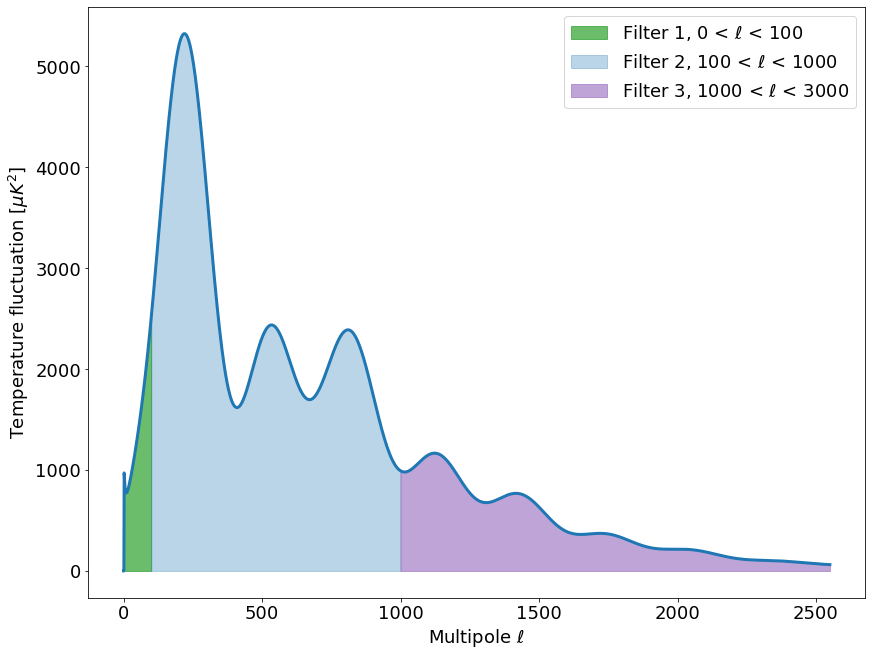

In [5]:
ls = np.loadtxt('ls.txt')
totCL = np.loadtxt('totCL.txt')

x = np.zeros(len(totCL[:,0]))
x[100:1000]=5600
x1 = np.zeros(len(totCL[:,0]))
x1[1:100]=5600
x2 = np.zeros(len(totCL[:,0]))
x2[1000:2600]=5600

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,9))
ax.plot(ls,totCL[:,0], color='C0', linewidth=3)
ax.fill_between(ls, totCL[:,0],  where=(ls < x1), color='C2', alpha=0.7, label="Filter 1, 0 < $\ell$ < 100")
ax.fill_between(ls, totCL[:,0],  where=(ls < x), color='C0', alpha=0.3, label="Filter 2, 100 < $\ell$ < 1000")
ax.fill_between(ls, totCL[:,0],  where=(ls < x2), color='C4', alpha=0.6, label="Filter 3, 1000 < $\ell$ < 3000")
ax.legend(loc = "upper right")
ax.set_xlabel('Multipole $\ell$')
ax.set_ylabel('Temperature fluctuation [$\mu K^2$]')

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


fs = 3000.0 
order = 10 # order of the bandpass filter
cutoff = [0, 100.0, 1000]

# Filter definition
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff[2], fs, order)
# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

b2, a2 = butter_lowpass(cutoff[1], fs, order)
w2, h2 = freqz(b2, a2, worN=8000)

filter_1 = np.abs(h2)
filter_2 =  np.abs(h) - np.abs(h2)
filter_3 = 1-(filter_2 + np.abs(h2))

filter_ = [filter_1, filter_2, filter_3]

plt.plot((fs * np.pi) * w *0.1, filter_1, 'C0')
plt.plot((fs * np.pi) * w *0.1, filter_2 'C1')
plt.plot((fs * np.pi) * w *0.1, filter_3, 'C2')
plt.xlim(0, fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Check the sum is one
plt.plot((fs * np.pi) * w *0.1, filter_1+filter_2+filter_3, 'r')
plt.title("Sum of the 3 Lowpass Filters Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [ ]:
map_frequency_list=[100, 143, 217, 353, 545, 857]
alm_list = []

for map_frequency in map_frequency_list:
    # Read the map 
    # map_guide = hp.read_map("Maps/HFI_SkyMap_%i_512_R2.00_full_ready_masked.fits" % map_frequency)
    map_guide = hp.read_map("Maps/Maps_Resolution_2048/HFI_SkyMap_%i_2048_R2.00_full_ready_masked.fits" % map_frequency)
    print(map_frequency)
    
    alm_list_filter = []
    
    # Filter the map 
    for i in range(len(filter_)):
        print(i)
        
        # Plot the filter 
        plt.figure()
        plt.plot((fs * np.pi) * w *0.1, filter_[i], label="order = %d" % order)
        plt.xlabel('Harmonic l ')
        
        # Extract alm (harmonic spheric coeff) from the map 
        alm = hp.sphtfunc.map2alm(map_guide)
        # Apply the fileter on alm
        filter_alm = hp.almxfl(alm, filter_[i])
        
        alm_list_filter.append(filter_alm)
        
        # Create a new map with the filtered alm
        map_new = hp.sphtfunc.alm2map(filter_alm, 2048)
        
        
        # Write the map 
        hp.write_map("Maps/Maps_Harmonic_Spheric/HFI_SkyMap_%i_2048_R2.00_filter_%i.fits" % (map_frequency, i+1), map_new, overwrite=True)
        
        # Plot 
        hp.mollview(map_new,norm="hist")
        hp.graticule()
        
    alm_list.append(alm_list_filter)
        
        

## ILC Constrained on the filtered maps.

### Separation Component Method 
An important part of doing a full analysis of
CMB maps is to start by separating the mixed astrophysical sources. In this context, many component separation techniques were developed. In our work, we used the so-called Inter
Linear Combination[1][2][3], ILC method to extract the thermal SZ signal from the CMB.

### Apply ILC on the filtered maps and sum to obtain the best SZ map.

In [ ]:
def ILC_constrained_weight_map(map_list, CMB = False):
    """
    Function to extract the constrained ILC weights for each CMB maps. 
    Args: map_list
    
    Return:
        List ok ILC weights for CMB and for SZ.
    """
    
    # Compute covariance of the masked maps (the mask uncode as UNSEEN value)
    cov = np.ma.cov(map_list)
    cov_inv = np.linalg.inv(cov)
    CMB_coef = np.ones(len(cov)) 
    
    # SZ_coef from documentation
    SZ_a_coef = np.array([-1/0.24815, -1/0.35923, 1/5.152, 1/0.16109, 1/0.06918, 1/0.0380])
    
    ilc_weights = []
    
    if CMB == True :
        a = CMB_coef
        b = SZ_a_coef
    else :
        b = CMB_coef
        a = SZ_a_coef
        
    ilc_weights= ((b.T@cov_inv@b) * a.T@cov_inv - (a.T@cov_inv@b) * b.T@cov_inv)/((a.T@cov_inv@a)*(b.T@cov_inv@b) - (a.T@cov_inv@b)*(a.T@cov_inv@b))
    
    return ilc_weights.T
    

def ILC(map_list, w_list, filter_number):
    """
    Function to extract the SZ for each maps.  
    Args: map_list, ILC_weight_list
    
    Return:
        New CMB maps.
        
    """
    map_cmb = sum (maps*w for maps, w in zip(map_list,w_list))
    hp.write_map("Maps/Maps_Harmonic_Spheric/HFI_SkyMap_2048_R2.00_filter_%i.fits" % (filter_number),map_cmb, overwrite=True)

def main(): 
    
    fs = 3000.0 
    order = 10 # order of the bandpass filter
    cutoff = [0, 100.0, 1000]
    
    
    # List of frequency maps
    map_frequency_list=[100, 143, 217, 353, 545, 857]
    
    # Create a mask for the galactic center based on the 857 Map
    mask = mask_create()
    SZ_a_coef = np.array([-1/0.24815, -1/0.35923, 1/5.152, 1/0.16109, 1/0.06918, 1/0.0380])
    
    # Read and mask reduced map
    # One loop to go read all the maps for on specific filter and re-apply the mask 
    # Then compute the SZ weights for this specific filter and apply the weight to perform constrained SZ component separation. 
    
    for i in range(len(cutoff)):
        
        print("")
        print("")
        print("Compute the ILC weights for the filter l cutoff",  cutoff[i], ":")
        map_list = []
        w_list_SZ = 0 
        print("")
        print("Read and mask reduced map at each frequency.")
        
        for map_frequency in map_frequency_list:
            map_cmb = hp.read_map("Maps/Maps_Harmonic_Spheric/Filtered_2048_%i/HFI_SkyMap_%i_2048_R2.00_filter_%i.fits" % (map_frequency, map_frequency, i+1))
            map_cmb_masked = hp.ma(map_cmb)
            map_cmb_masked.mask = np.logical_not(mask)
            map_list.append(map_cmb_masked)
            
            #hp.mollview(map_cmb_masked,norm="hist")
            #hp.graticule()

        # Compute CMB and SZ weights
        w_list_SZ = ILC_constrained_weight_map(map_list, False)
        print("")
        print("Somme des poids SZ, b:", np.dot(w_list_SZ ,SZ_a_coef))
        print("Somme des poids SZ, a:", sum(w_list_SZ))
        print("")
        print("ILC weights for the filter l cutoff ",  cutoff[i], ":")
        print(w_list_SZ)
        
        # Apply ILC to the map to extract SZ only
        ILC(map_list, w_list_SZ, i+1)
        mp1_c_sz = hp.read_map("Maps/Maps_Harmonic_Spheric/HFI_SkyMap_2048_R2.00_filter_%i.fits" % (i+1))
        
        # Remove galactic dipole from the SZ map and Plot 
        mp1_c_sz_ = hp.remove_dipole(mp1_c_sz, gal_cut=30)
        hp.mollview(mp1_c_sz_,norm="hist", title = "ILC Constrained SZ, filter %i" %(i+1))
        hp.graticule()
            


main()

In [ ]:
mp1_c_sz = hp.read_map("Maps/HFI_SkyMap_2048_R2.00_full_SZ_ILC_Constrained.fits")
# Remove galactic dipole from the SZ map and Plot 
mp1_c_sz_ = hp.remove_dipole(mp1_c_sz, gal_cut=25)
hp.gnomview(mp1_c_sz_, rot=[0, 90], title="GnomView ILC Constrained", unit="mK", format="%.2g")
     
mp1_c_sz1 = hp.read_map("Maps/Maps_Harmonic_Spheric/HFI_SkyMap_2048_R2.00_filter_1.fits")
mp1_c_sz_1 = hp.remove_dipole(mp1_c_sz1, gal_cut=25)
mp1_c_sz2 = hp.read_map("Maps/Maps_Harmonic_Spheric/HFI_SkyMap_2048_R2.00_filter_2.fits")
mp1_c_sz_2 = hp.remove_dipole(mp1_c_sz2, gal_cut=25)
mp1_c_sz3 = hp.read_map("Maps/Maps_Harmonic_Spheric/HFI_SkyMap_2048_R2.00_filter_3.fits")
mp1_c_sz_3 = hp.remove_dipole(mp1_c_sz3, gal_cut=25)

map_sum =   mp1_c_sz_2 + mp1_c_sz_1+ mp1_c_sz_3 
hp.write_map("Maps/Maps_Harmonic_Spheric/HFI_SkyMap_2048_R2.00_filter_sum.fits" ,map_sum, overwrite=True)

#map_filters = hp.read_map("Maps/Maps_Harmonic_Spheric/HFI_SkyMap_2048_R2.00_filter_sum.fits" )


 # Vizualisation of a galaxy cluster from SZ map
hp.gnomview(map_sum, rot=[0, 90], title="GnomView ILC Constrained SZ, filter", unit="mK", format="%.2g")

# Identify Cluster on the Best SZ Map

Now that we produced a map that highlights the thermal SZ effect, our next step is to set up
a routine to detect and identify clusters.
To develop and test our algorithm we focus on a 10 by 10° region of the map located on the north celestial pole.

## Patch on our best SZ map 

To build this region (or patch) of the map, we perform sky projection to map the sky onto a
flat image. The WCS (World Coordinate System) routine allows building such projection by specifying the targeted coordinates (north celestial pole), and the pixel scale.

In [ ]:
nside = 2048
map_guide = hp.read_map("HFI_SkyMap_2048_R2.00_filter_sum.fits")  

# Create a new WCS object.  The number of axes must be set from the start
w = wcs.WCS(naxis=2)
# Set up an "Airy's zenithal" projection
# Vector properties may be set with Python lists, or Numpy arrays
w.wcs.crpix = [177, 177] #central pixel
w.wcs.cdelt = np.array([-0.028333, 0.028333]) #scaling
w.wcs.crval = [96.38, 29.8] # central value (coord en phi theta du pixel pointé (0, -90) )
w.wcs.ctype = ['GLON-TAN','GLAT-TAN'] #RA---AIR
patch_size = 10 # Patch size in degree 

# Create an empty map of dimensions patch_size
yy, xx = np.indices((384,384))
zz = xx*0 

# Find the healpix map index associated to the sky coordianate
world = w.wcs_pix2world(xx,yy, 0)
   
# Find the pixel value at the sky coordinate on the CMB map  
cmb_map_index = hp.ang2pix(nside, world[0], world[1], lonlat = True)
cmb_pixel_values = map_guide[cmb_map_index]


# Fill the empty map with the pixel value at the sky coordinate on the CMB map.
zz = cmb_pixel_values

# Flip the map 
zz_= np.fliplr(zz)  
    
# Display the patch map 
fig = plt.figure(0, figsize=(12, 10))
h = plt.imshow(map_new)
plt.colorbar()
plt.show()

In [ ]:
def spherical_mask(matrix, center_pixel, radius=12):
        """
    Function to create a mask on a cluster. 
    Args: patch map, pixel in the center of the cluster, radius of the spherical mask in arcmin.
    
    Return: The patch map with one spherical mask on the targeted region. 
    
        """
    # Transform radius from arcmin to pixel
    pixel_size = 1.7 #arcmin
    radius_pixel = int(radius/pixel_size) + 1
    center_pixel = np.array(center_pixel)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            
            pixel = np.array([i,j])
            norme = np.linalg.norm(pixel-center_pixel)
            
            if norme <= radius :
                matrix[i,j] = 0
                
    return matrix

## Cluster detection on the Patch  

The routine implemented to detect clusters on this patch is simple. The algorithm finds the maximum value pixel on the patch -our first candidate cluster-. Assuming that the cluster size is equal or less than Planck FWHM (which we have smoothed to 10 arcmins see Section
2), the cluster area is masked with a round mask of radius 10 arcmins. The algorithm then looks for the second maximum-valued pixel on the map and proceeds in the same way. At each candidate cluster identification the Signal-to-Noise Ratio is computed and the cluster search stops when the SNR becomes equal to or less than 6.

In [ ]:
# Create an empty dictionary to store the list of candidate cluster
cluster_dict = {}
cluster_index =[]
cluster_ra_dec = []

# Lower the noise level on the patch 
map_new = zz_/np.mean(zz_)

i = 0 
SNR = 10 
while SNR > 6 :
    i = i+1
    
    # Update patch 
    map_old = map_new 
    
    # Find the first cluster candidate
    cluster_candidate = np.max(map_old)
    max_index = np.array([np.where(map_old==cluster_candidate)[0][0],np.where(map_old==cluster_candidate)[1][0]])
    cluster_index.append([max_index[0],max_index[1]])
    
    # Get the Galactic coordinate of the candidate cluster
    world = w.wcs_pix2world(np.where(map_old==cluster_candidate)[0][0],np.where(map_old==cluster_candidate)[1][0], 0)
    cluster_dict['Cluster_%i sky coordinate'% (i)] = world[0], world[1]
    
    # Get the RA DEC coordinate of the candidate cluster
    gc = SkyCoord(l=world[0]*u.degree, b=world[1]*u.degree, frame='galactic')
    cluster_ra_dec.append(gc.transform_to('fk5')  )
    
    # Mask the candidate cluster on the patch 
    map_new = spherical_mask(map_old , max_index)
    h = plt.imshow(map_new)
    plt.show()
    
    # Compute SNR for the candidate cluster
    SNR = cluster_candidate/np.std(map_old)
    cluster_dict['Cluster_%i Snr'% (i)] = SNR
    print("Cluster %i :" %i, max_index[0], max_index[1], "with max intensity value", cluster_candidate, "SNR", SNR)
    
print("Candidate Cluster cluster dictionary", cluster_dict)

## Vizualisation

In [ ]:
import plotly.express as px

img = map_new
fig = px.imshow(img,color_continuous_scale='Viridis', origin = "upper",title="Candidate Cluster, Patch centered on celestial pole")

index = [8,243,369,300,156,323,317,292,181,210,21,332,37,276]
# Shape defined programatically
for i in range(len(index)-1):
    fig.add_shape(type='rect',
        y0=index[i]-8, y1=index[i]+8, x0=index[i+1]-8, x1=index[i+1]+8,
       )
fig.show()

## Cluster matching using Planck SZ Catalog 

Comparison with Planck 2nd Sunyaev-Zeldovich Source Catalog The Planck 2nd Sunyaev-Zeldovich Source Catalog contains the all-sky Planck catalog of Sunyaev-Zeldovich
(SZ) sources detected from the 29 months full Planck mission data. The PSZ2 catalogs 13 clusters on a 10° by 10° area centered at the north celestial pole. For each candidate cluster we have detected, we try to find its best match on the PSZ2 finding the lowest relative error between the candidate cluster position and the ones from the catalog.

In [60]:
def findSecondSmallest(lst):
            """
    Function to find the second minimum value of an array. 
    Args: aray.
    
    Return: The second minimum of the input array.
    
        """
    firstSmallest = min(lst[0],lst[1])
    secondSmallest = max(lst[0],lst[1])
    for i in range(2,len(lst)):
        if lst[i] < firstSmallest:
            secondSmallest = firstSmallest 
            firstSmallest = lst[i]
        elif lst[i] < secondSmallest and firstSmallest < lst[i]:
            secondSmallest = lst[i]
    return secondSmallest 

def confidence_level(array):
        """
    Function 
    Args: 
    
    Return: 
    
        """
    index = np.where(array == np.min(array))
    index = np.int(index[0])
    index_2 = np.where(array == findSecondSmallest(array))
    index_2 = np.int(index_2[0])
    
    diff1 = np.min(array)
    
    correspondance1 = np.array([True_cluster[0][index], True_cluster[1][index]])
    
    correspondance2 = np.array([True_cluster[0][index_2], True_cluster[1][index_2]])
    
    return np.min(array), findSecondSmallest(array), diff, correspondance1, correspondance2

In [76]:
True_cluster = np.array([[257.546,257.611,258.185,258.419,261.928,261.944,266.87,268.637,275.486,277.784 ,278.105 ,278.533,282.752],
                         [62.3626,68.7321,64.059,69.3734 ,70.5941,61.5086 ,71.3703,68.0406,64.3488,62.2481,64.8278,70.9673  ,68.8065 ]])

Candidate_cluster = np.array([[264.148,262.827,259.437,262.947,267.622,259.466,261.627,282.582], 
                              [71.2145,60.9134,66.7695,62.3892,66.3971,65.1952,70.2941,70.9956]])

correspondance = []

for i in range(np.shape(Candidate_cluster)[1]):
    err_abs_ = []
    candidate = np.array([Candidate_cluster[0][i], Candidate_cluster[1][i]])
    for j in range(np.shape(True_cluster)[1]):
        true = np.array([True_cluster[0][j], True_cluster[1][j]])
        err_abs = ((np.linalg.norm(true - candidate))/(np.linalg.norm(true)))*100
        err_abs_.append(err_abs)
        
    err_abs_one, second_err_abs, diff1, correspondance1, correspondance2 = confidence_level(err_abs_)
    correspondance.append(correspondance1)
    
    print("Candidate %i matches best with Cluster"%(i+1), correspondance1, "absolute Error", err_abs_one, "%")
    print("Candidate %i matches 2nd best  Cluster"%(i+1), correspondance2, "absolute Error", second_err_abs, "%")
    print("")
        

Candidate 1 matches best with Cluster [261.928   70.5941] absolute Error 0.8497148112315521 %
Candidate 1 matches 2nd best  Cluster [266.87    71.3703] absolute Error 0.9869569106814101 %

Candidate 2 matches best with Cluster [261.944   61.5086] absolute Error 0.3957620598841433 %
Candidate 2 matches 2nd best  Cluster [257.546   62.3626] absolute Error 2.066591249951175 %

Candidate 3 matches best with Cluster [257.611   68.7321] absolute Error 1.0054237888436406 %
Candidate 3 matches 2nd best  Cluster [258.419   69.3734] absolute Error 1.0448983683660553 %

Candidate 4 matches best with Cluster [261.944   61.5086] absolute Error 0.4960500588633252 %
Candidate 4 matches 2nd best  Cluster [258.185  64.059] absolute Error 1.8970007928503139 %

Candidate 5 matches best with Cluster [268.637   68.0406] absolute Error 0.6970494594719461 %
Candidate 5 matches 2nd best  Cluster [266.87    71.3703] absolute Error 1.8207270204528725 %

Candidate 6 matches best with Cluster [258.185  64.059] ab

## Visualization

In [ ]:
index_true = []

for i in range(np.shape(correspondance)[0]):
    
        true_candidate_coord = correspondance[i]
        
        # Get the Galactic coordinate of the candidate cluster
        gc = SkyCoord(ra=true_candidate_coord[0]*u.degree, dec=true_candidate_coord[1]*u.degree, frame='fk5')
        cluster_galactic = gc.transform_to('galactic')  

        # Get the pix coordinate of the candidate cluster
        cluster_pix = w.wcs_world2pix(cluster_galactic[0],cluster_galactic[1], 0)
        
        index_true.append(cluster_pix)

In [89]:
import plotly.express as px

img = map_new
fig = px.imshow(img,color_continuous_scale='Viridis', origin = "upper",title="Candidate Cluster, Patch centered on celestial pole")

index_candidate = [8,243,369,300,156,323,317,292,181,210,21,332,37,276]
        
# Shape defined programatically
for i in range(len(index)-1):
    fig.add_shape(type='rect',
        y0=index_candidate[i]-1, y1=index_candidate[i]+1, x0=index_candidate[i+1]-1, x1=index_candidate[i+1]+1,
        color = "continent", color_discrete_sequence=px.colors.qualitative.G10)
    fig.add_shape(type='circle',
        y0=index_true[i]-1, y1=index_true[i]+1, x0=index_true[i+1]-1, x1=index_true[i+1]+1,
       )
fig.show()

ModuleNotFoundError: No module named 'plotly'

# Links and papers:

1. CMB and SZ effect separation with Constrained Internal Linear Combinations (Mathieu Remazeilles, Jacques Delabrouille, Jean-Fran¸cois Cardoso, 2018)


2. A full sky, low foreground, high resolution CMB map from WMAP (J. Delabrouille, J.-F. Cardoso, M. Le Jeune, M. Betoule, G. Fay, and F. Guilloux, A&A 493, 835–857 (2009))


3. https://arxiv.org/pdf/astro-ph/0403098.pdf On Foreground Removal From The Wilkinson Microwave Anisotropy Probe Data By An Internal Linear Combination Method: Limitations And Implications (H. K. Eriksen et al, 2004)


4. MILCA, a Modified Internal Linear Combination Algorithm to extract astrophysical emissions from multi-frequency sky maps (G. Hurier, J. F. Macías-Pérez, and S. Hildebrandt, A&A September 19, 2018
)


5. https://arxiv.org/pdf/0811.4277.pdf "Internal Linear Combination" method for the separation of CMB from Galactic foregrounds in the harmonic domain (R. Vio and P. Andreani, 2008)


6. https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/ Public download link for CMB maps


7. https://healpix.sourceforge.io/ Healpix Forge 